# Amils et al. 2023

In [1]:
# Add higher directory to python modules path

import sys

sys.path.append("..")

In [2]:
import os
import yaml

import plotly.express as px

import pandas as pd

from modules.data.amils2023.data_loader import Amils2023DataLoader

In [3]:
# Load config

with open("../modules/config.yml") as config_file:
    config = yaml.safe_load(config_file)

In [4]:
data_loader = Amils2023DataLoader()

### Elements data

Dataset S2 - ICP-MS elemental analysis of core samples (ppm)

In [5]:
elements_df_long = data_loader.get_elements()
elements_df_long

,Depth,Species,Concentration (ppm)
0,121.8,Li,131.23
1,130.8,Li,1244.97
2,138.0,Li,0.66
3,139.4,Li,89.95
4,190.0,Li,0.14
...,...,...,...
667,519.1,Pb,20.19
668,544.0,Pb,71.89
669,568.6,Pb,19.71
670,596.0,Pb,0.00


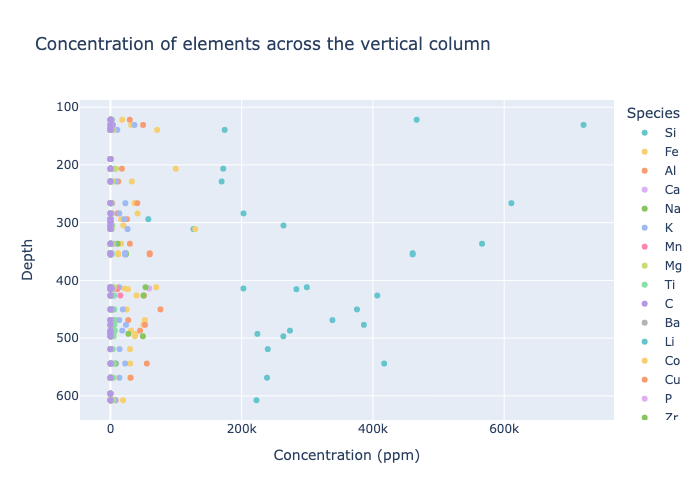

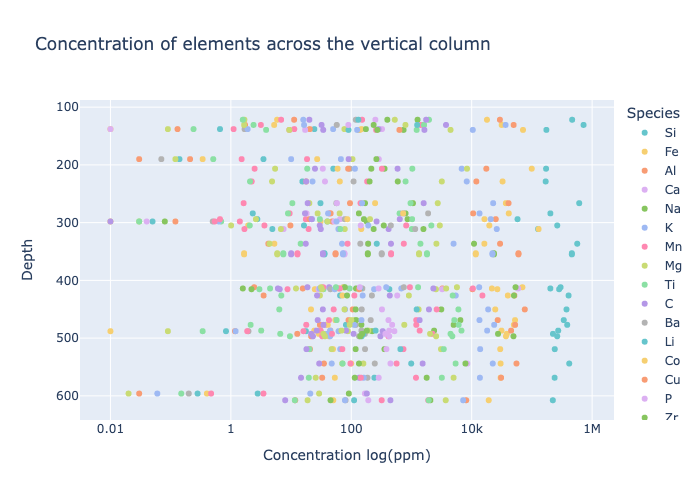

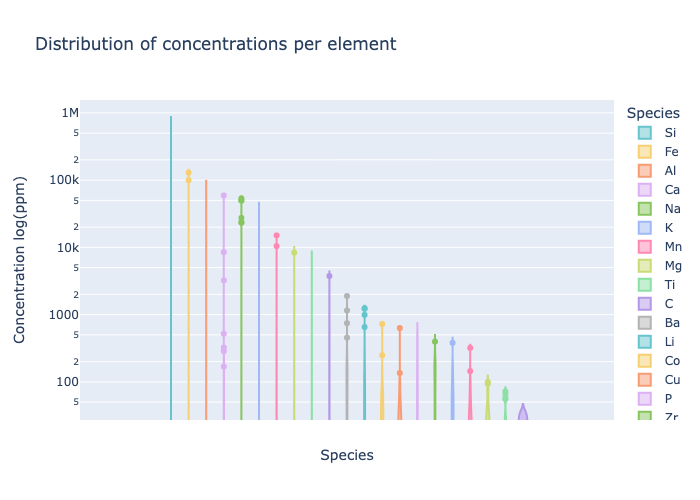

In [6]:
# Get sorted elements by their maximum concentration
elements_sorted = elements_df_long\
    .groupby("Species")\
    .max()\
    .sort_values("Concentration (ppm)", ascending=False)\
    .index\
    .to_list()

fig = px.scatter(
    data_frame=elements_df_long,
    x="Concentration (ppm)",
    y="Depth",
    color="Species",
    color_discrete_sequence=px.colors.qualitative.Pastel,
    category_orders={"Species": elements_sorted},
    title="Concentration of elements across the vertical column"
)
fig['layout']['yaxis']['autorange'] = "reversed"
fig.show("png")

fig = px.scatter(
    data_frame=elements_df_long,
    x="Concentration (ppm)",
    log_x=True,
    y="Depth",
    color="Species",
    color_discrete_sequence=px.colors.qualitative.Pastel,
    category_orders={"Species": elements_sorted},
    title="Concentration of elements across the vertical column"
)
fig.update_layout(xaxis_title="Concentration log(ppm)")
fig['layout']['yaxis']['autorange'] = "reversed"
fig.show("png")

fig = px.violin(
    data_frame=elements_df_long,
    y="Concentration (ppm)",
    log_y=True,
    color="Species",
    color_discrete_sequence=px.colors.qualitative.Pastel,
    category_orders={"Species": elements_sorted},
    title="Distribution of concentrations per element"
)
fig.update_layout(
    xaxis_title="Species",
    yaxis_title="Concentration log(ppm)"
)
fig.show("png")

### Anions and organic compounds data

Dataset S3 - Ionic chromatography of BH10 soluble organic and inorganic anions (ppm)

In [7]:
anions_df_long = data_loader.get_anions()
anions_df_long

,Depth,Species,Concentration (ppm)
0,90.10,pH,7.500000
1,94.90,pH,7.500000
2,100.00,pH,8.000000
3,102.60,pH,7.500000
4,103.32,pH,7.000000
...,...,...,...
1685,600.00,Oxalate,0.254286
1686,605.38,Oxalate,0.625714
1687,607.60,Oxalate,0.091429
1688,609.90,Oxalate,0.160000


### Cations data

Table S1 - Soluble cations (ppm)

In [8]:
cations_df_long = data_loader.get_cations()
cations_df_long

,Depth,Species,Concentration (ppm)
0,121.8,Fe2+,0.60
1,130.8,Fe2+,0.20
2,139.4,Fe2+,0.60
3,206.6,Fe2+,1.17
4,228.7,Fe2+,16.80
...,...,...,...
103,538.4,NH4+,13.20
104,544.0,NH4+,21.10
105,588.6,NH4+,27.00
106,607.6,NH4+,21.20


### Gases data

Table S7 - Occluded gases and natural activities at different depths (10/8/22)

In [9]:
gases_df_long = data_loader.get_gases()
gases_df_long

,Depth,Species,Concentration (ppm)
0,90,H2,40.0
1,102.6,H2,0.0
2,121.8,H2,2000.0
3,130.8,H2,0.0
4,139.4,H2,250.0
...,...,...,...
106,520,CH4,10.0
107,538.5,CH4,5.0
108,568.6,CH4,5.0
109,607.6,CH4,5.0


### Medium for MICOM

In [10]:
medium_df = data_loader.get_data()
medium_df

,Depth,Species,Concentration (ppm)
0,121,Li,131.23
1,130,Li,1244.97
2,138,Li,0.66
3,139,Li,89.95
4,190,Li,0.14
...,...,...,...
2576,520,CH4,10.00
2577,538,CH4,5.00
2578,568,CH4,5.00
2579,607,CH4,5.00


In [11]:
# Save for later analysis with MICOM

medium_df.to_csv(
    os.path.join(
        config["paths"]["micom"],
        "amils2023/",
        "medium.csv"
    ),
    index=False,
    header=True,
    sep=";"
)

### Microbial data

Table S8-2

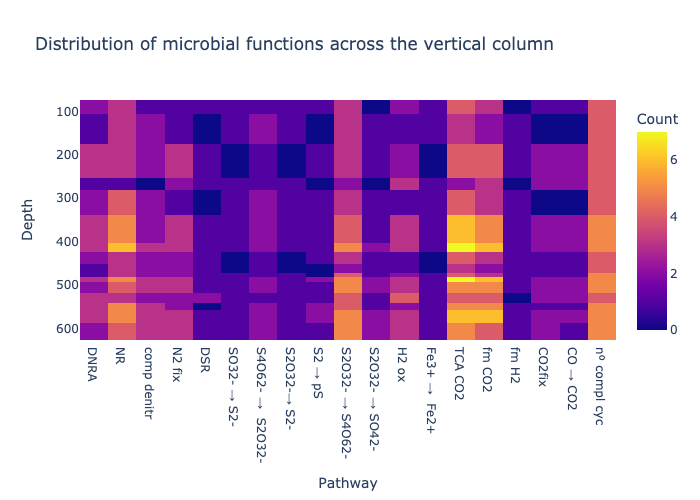

In [12]:
# ---------------------------------------------------------------------------- #
# Table S8-2 - Number of microbial species detected at different depths which
# have the potential of carry out key metabolic pathways of the C, H, N, S and
# Fe cycles. 

microbes_df = pd.read_excel(
    os.path.join(
        data_loader.data_dir,
        "emi16291-sup-0001-supinfo-tables8-2.ods"
    ),
    sheet_name="Sheet1"
)

# Rename pathway column
microbes_df = microbes_df.rename(columns={"Pathway/depth": "Pathway"})

# Drop last row containing the explanation
microbes_df = microbes_df.iloc[:-1, :].copy()

# Drop rows containing the cycles
microbes_df = microbes_df[
    ~microbes_df["Pathway"].str.endswith(" cycle")
]

# Convert to numeric
numeric_cols = [
    col for col in microbes_df.columns
    if col not in ["Pathway"]
]
microbes_df[numeric_cols] = microbes_df[numeric_cols].apply(
    pd.to_numeric,
    errors="coerce"
)

fig = px.imshow(
    img=microbes_df[numeric_cols].T.to_numpy(),
    x=microbes_df["Pathway"],
    y=numeric_cols,
    labels=dict(
        x="Pathway",
        y="Depth",
        color="Count"
    ),
    aspect="equal",
    title="Distribution of microbial functions across the vertical column"
)
fig.show("png")

Depths with all microbial functions analyzed: [392, 416, 477, 487, 497, 544, 569, 607]


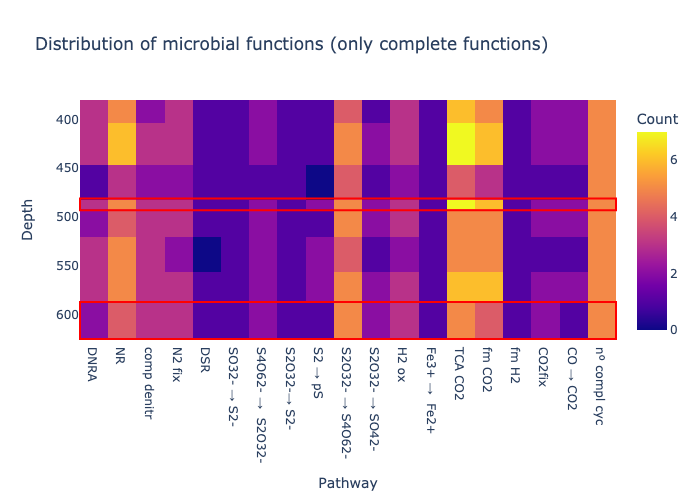

In [13]:
complete_depths = microbes_df[microbes_df["Pathway"] == "nº compl cyc"]
complete_depths = complete_depths[complete_depths == 5]\
    .dropna(axis=1)\
    .columns

print(
    "Depths with all microbial functions analyzed:",
    complete_depths.tolist()
)

fig = px.imshow(
    img=microbes_df[complete_depths].T.to_numpy(),
    x=microbes_df["Pathway"],
    y=complete_depths,
    labels=dict(
        x="Pathway",
        y="Depth",
        color="Count"
    ),
    aspect="equal",
    title="Distribution of microbial functions (only complete functions)"
)
fig.add_shape(
    type="rect",
    x0=0.0,
    x1=1.0,
    y0=481,
    y1=493,
    xref="paper",
    yref="y",
    line_color="red"
)
fig.add_shape(
    type="rect",
    x0=0.0,
    x1=1.0,
    y0=587,
    y1=625,
    xref="paper",
    yref="y",
    line_color="red"
)
fig.show("png")